In [1]:
import numpy as np
import scipy
from scipy import signal
import os
import matplotlib.pyplot as plt

from algorithm.multi_pitch_detection_fourier import CisoidDict, smooth
from data.data_utils import play_audio, read_audio

from hyperparameters import PITCH_FREQUENCY_GRID
audio_dir = "toy_examples"

In [2]:
import numpy as np

np.array([(1,2),(2,3),(3,4)]).shape

(3, 2)

# Toy example: single-chord transcription with square waves of 4 pitches

In [3]:
N = 800
fs = 8000
real_t = np.arange(N)/fs

f_candidates = PITCH_FREQUENCY_GRID[12*4:12*5:3]
pitch_num = len(f_candidates)
raw_templates = [None for _ in range(pitch_num)]
f_base_scipy = 1/(2*np.pi)
for p in range(pitch_num):
    raw_templates[p] = signal.square(real_t/f_base_scipy*f_candidates[p])

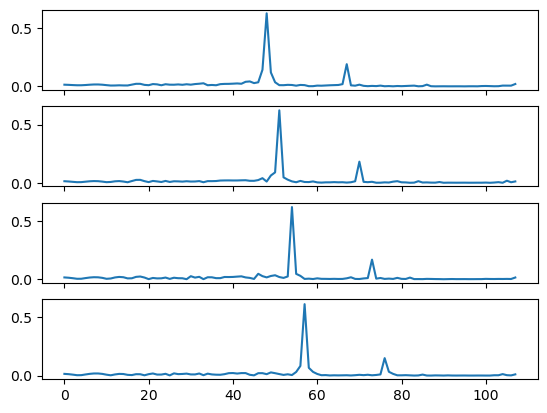

In [4]:
sq_wave_dict = CisoidDict(raw_templates, fs, smoothify = True, plot = False)

cisoid_dict = sq_wave_dict.cisoid_dict
fig, ax = plt.subplots(len(cisoid_dict),1, sharex=True, sharey=True)
for i, sq_wave_pitches in enumerate(cisoid_dict):
    ax[i].plot(abs(sq_wave_pitches))

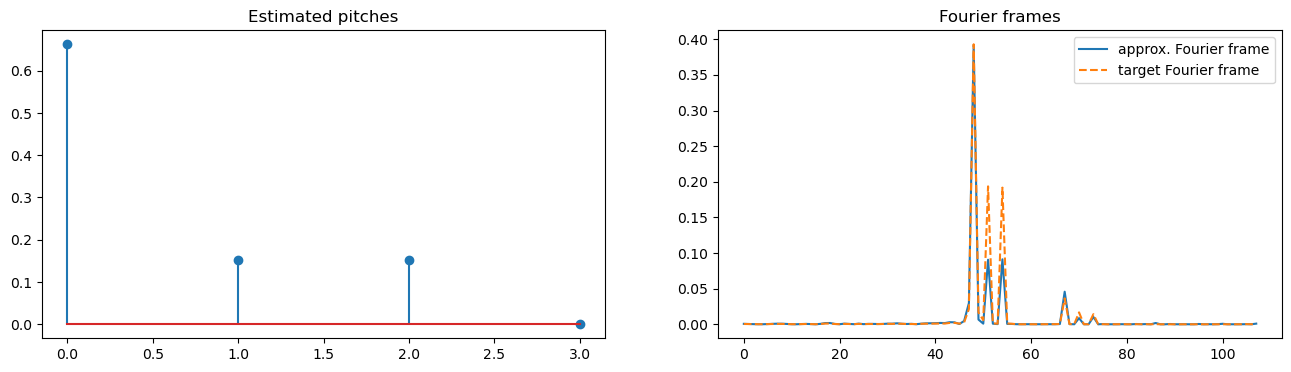

In [5]:
x = 1*scipy.signal.square(real_t/f_base_scipy*f_candidates[0]) + \
    0.5*scipy.signal.square(real_t/f_base_scipy*f_candidates[1]) + \
    0.5*scipy.signal.square(real_t/f_base_scipy*f_candidates[2])
amp_x_pitch = sq_wave_dict.single_chord_transcription_powergram(x, plot = False)
a_tilde = sq_wave_dict.apply_frame_analysis_operator(x)
power_dict = np.abs(sq_wave_dict.cisoid_dict**2)

fig, ax = plt.subplots(1,2, figsize = (16,4))
ax[0].stem(abs(amp_x_pitch))
ax[0].set_title("Estimated pitches")
ax[1].plot(abs(a_tilde ** 2))
ax[1].plot(abs(power_dict[0]*1 + power_dict[1]*0.5 + power_dict[2]*0.5), '--')
ax[1].set_title("Fourier frames")
ax[1].legend(["approx. Fourier frame", "target Fourier frame"])

# Transcription of square waves (12 pitches) given onsets

## Step 1: prepare templates

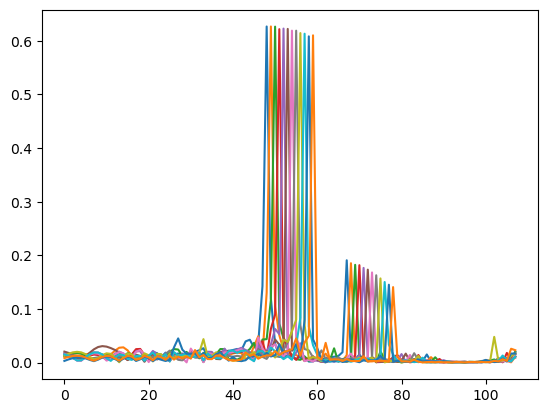

In [6]:
N = 800
fs = 8000
real_t = np.arange(N)/fs

f_candidates = PITCH_FREQUENCY_GRID[12*4:12*5]
pitch_num = len(f_candidates)
raw_templates = [None for _ in range(pitch_num)]
f_base_scipy = 1/(2*np.pi)
for p in range(pitch_num):
    raw_templates[p] = scipy.signal.square(real_t/f_base_scipy*f_candidates[p])
    
sq_wave_dict = CisoidDict(raw_templates, fs, smoothify = True, plot = False)
cisoid_dict = sq_wave_dict.cisoid_dict
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
for sq_wave_pitches in cisoid_dict:
    ax.plot(abs(sq_wave_pitches))

## Step 2: input audio and transcribe

In [7]:
N_signal = 40000
onsets = [0, 8000, 16000, 24000, 32000]
offsets = [8000, 16000, 24000, 32000, 40000]
x = np.zeros(N_signal)
t_chunk = np.arange(8000)/fs

x[onsets[0]:onsets[1]] = 1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[0]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[4]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[7]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[11])

x[onsets[1]:onsets[2]] = 1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[0]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[2]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[5]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[9])

x[onsets[2]:onsets[3]] = 1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[2]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[5]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[8]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[11])

x[onsets[3]:onsets[4]] = 1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[1]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[5]) + \
    1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[8]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[11])

x[onsets[4]:] = 1*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[0]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[4]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[7]) + \
    0.5*scipy.signal.square(t_chunk/f_base_scipy*f_candidates[11])

play_audio(x[np.newaxis,:], fs)

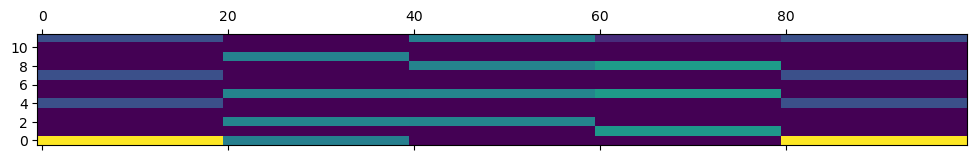

In [8]:
pitch_roll = sq_wave_dict.transcript_with_onsets(x, onsets, offsets)
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(12,8))
ax.matshow(abs(pitch_roll[0::400]).T, origin="lower")

# Transcription of external synthesizer (all pitches) given onsets, on a test piece

## Step 1: prepare templates

In [9]:
fs = 16000
audio_path = os.path.join(audio_dir, "all_notes.mp3")
x_template, fs = read_audio(audio_path, sample_rate = fs, combine_channels = True)
play_audio(x_template, fs)

note_dur = 60 / 30 / 4
note_n_sample = int(note_dur * fs)
N_notes = 65
start_offset = 500
x_template = x_template[start_offset:]

frequency_grid = PITCH_FREQUENCY_GRID#_FINER
pitch_start = 24 # to make the problem eazy to visualize, we use partial of the pitches
pitch_num = 25
pitch_end = pitch_start+pitch_num
raw_templates = [None for _ in range(pitch_num)]
f_base_scipy = 1/(2*np.pi)
for p in range(pitch_num):
    raw_templates[p] = x_template[(p+pitch_start)*note_n_sample+2000:(p+pitch_start)*note_n_sample+4000]
    
sq_wave_dict = CisoidDict(raw_templates, fs, frequency_grid = frequency_grid, smoothify = True, plot = False)
cisoid_dict = sq_wave_dict.cisoid_dict

D:\softwares\miniconda\envs\tylpy38\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


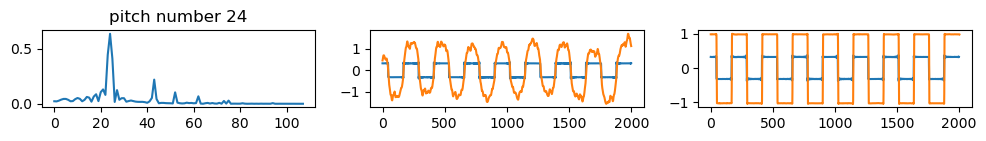

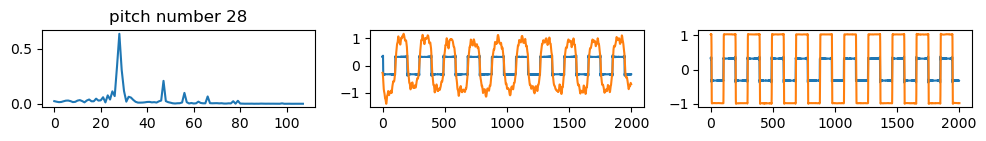

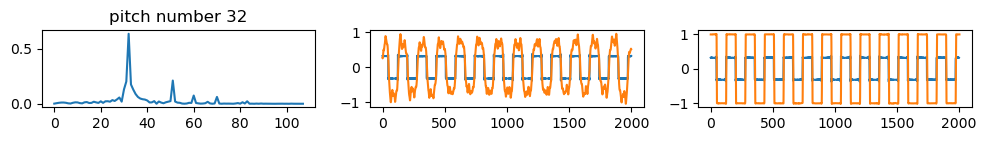

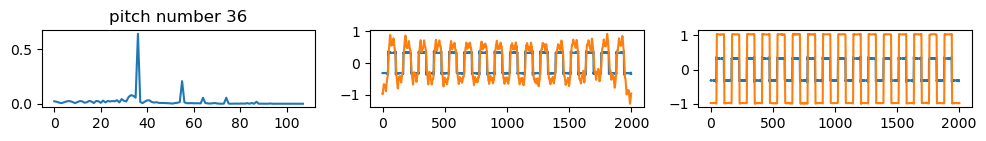

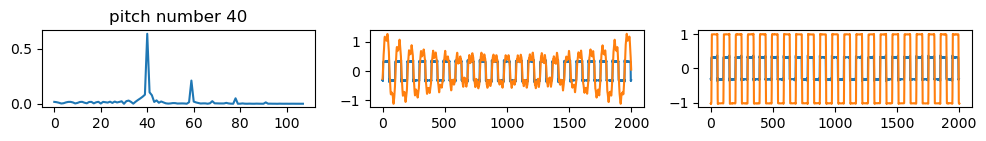

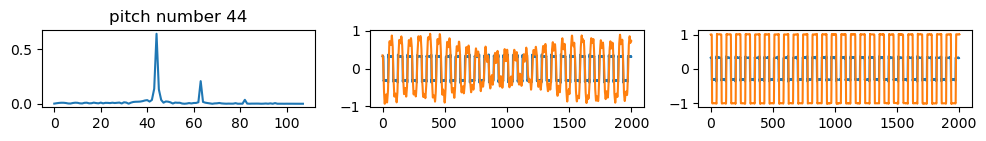

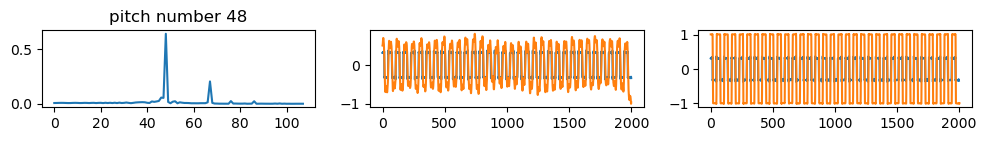

In [10]:
for p in range(pitch_num):
    if p % 4 == 0:
        sq_wave_pitches = cisoid_dict[p]
        x_recovered = sq_wave_dict.apply_frame_synthesis_operator(sq_wave_pitches, len(raw_templates[p]))
        play_audio(np.real(x_recovered), fs)

        fig, ax = plt.subplots(1,3, figsize=(12,1))

        ax[0].plot(abs(sq_wave_pitches))
        ax[0].set_title("pitch number "+str(pitch_start+p))
        ax[1].plot(raw_templates[p])
        ax[1].plot(x_recovered)
        ax[2].plot(raw_templates[p])
        ax[2].plot(smooth(raw_templates[p], window_len = 5))

## Step 2: input audio and transcribe

In [11]:
fs = 16000
audio_path = os.path.join(audio_dir, "bach_square_wave.mp3")
x, fs = read_audio(audio_path, sample_rate = fs, combine_channels = True)
play_audio(x, fs)
init_onset = 464
x = x[init_onset:]

note_dur = 60 / 120 / 2
note_n_sample = int(note_dur * fs)
N_notes = 15
onsets = [i*note_n_sample for i in range(N_notes)]
offsets = [(i+1)*note_n_sample for i in range(N_notes)]

notes_to_show = [None for _ in range(N_notes)]
f_base_scipy = 1/(2*np.pi)
for i in range(N_notes):
    notes_to_show[i] = x[onsets[i]:offsets[i]]
    
notes_to_show_dict = CisoidDict(notes_to_show, fs, frequency_grid = frequency_grid, smoothify = True, plot = False)
notes_to_show_cisoid_dict = notes_to_show_dict.cisoid_dict

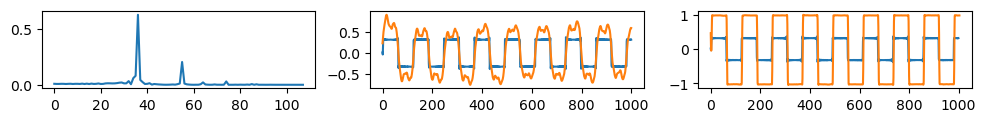

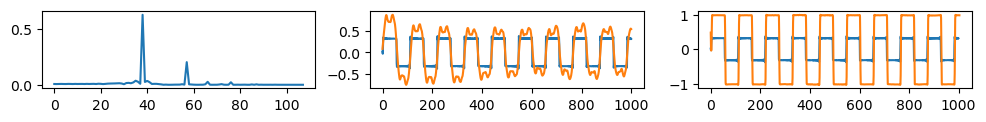

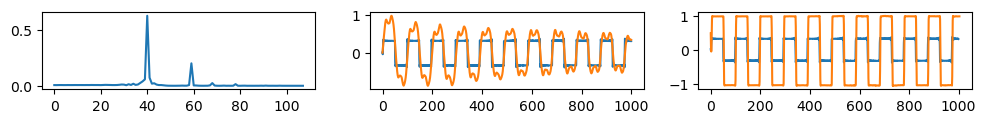

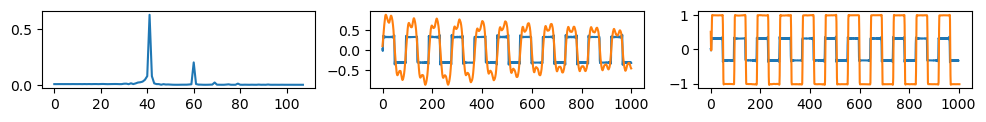

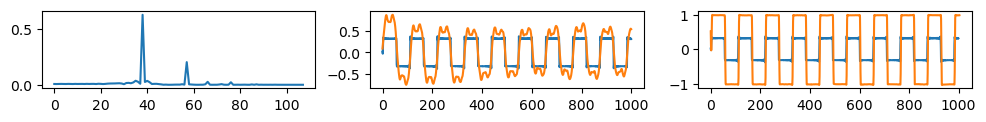

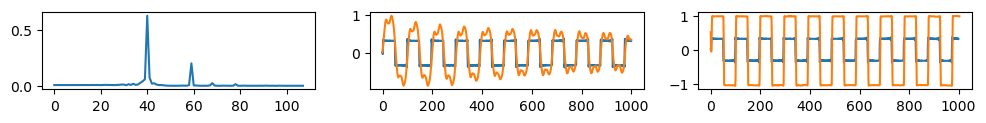

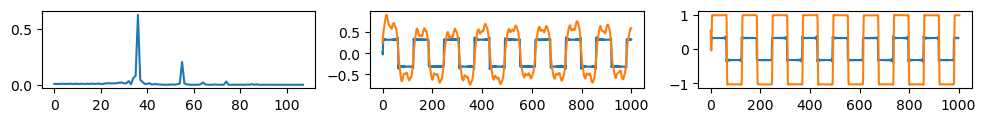

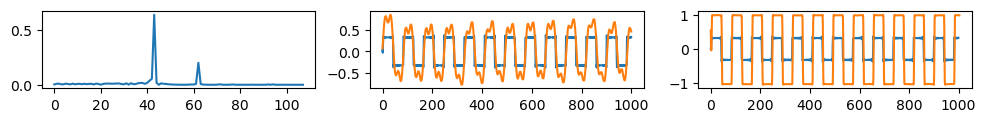

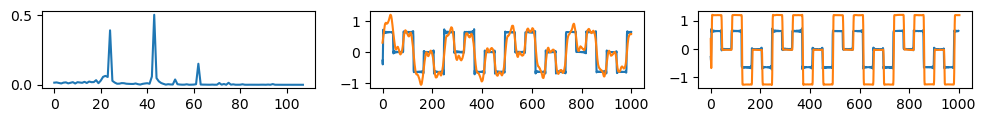

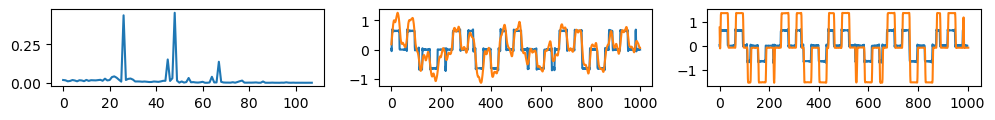

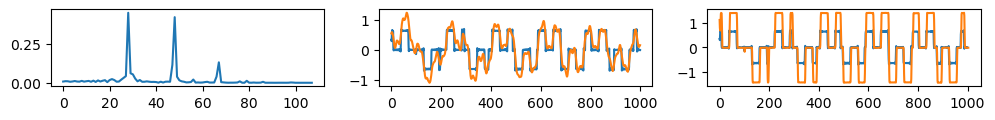

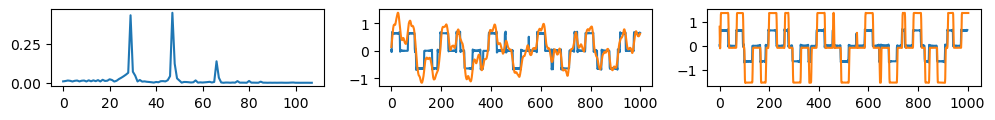

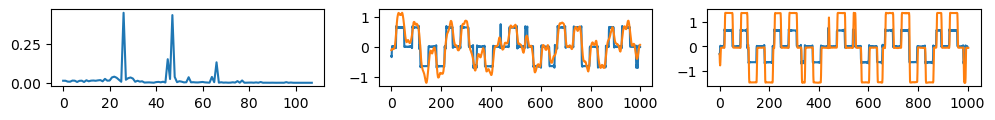

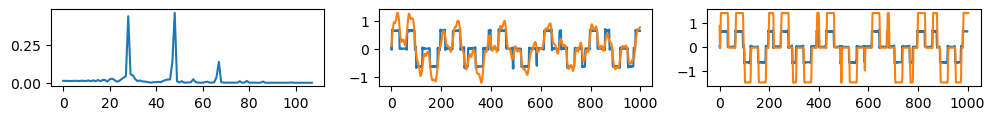

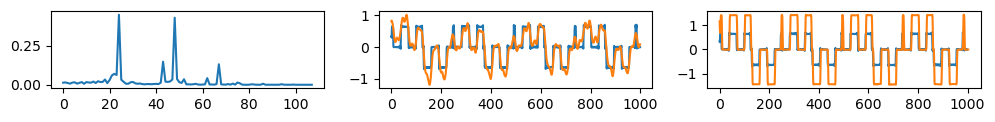

In [12]:
for i in range(N_notes):
    pitches = notes_to_show_cisoid_dict[i]
    x_recovered = sq_wave_dict.apply_frame_synthesis_operator(pitches, 1000)
    play_audio(np.real(x_recovered), fs)
    
    fig, ax = plt.subplots(1,3, figsize=(12,1))
    ax[0].plot(abs(pitches))
    ax[1].plot(x[onsets[i]:onsets[i]+1000])
    ax[1].plot(x_recovered)
    ax[2].plot(x[onsets[i]:onsets[i]+1000])
    ax[2].plot(smooth(x[onsets[i]:onsets[i]+1000], window_len = 5))

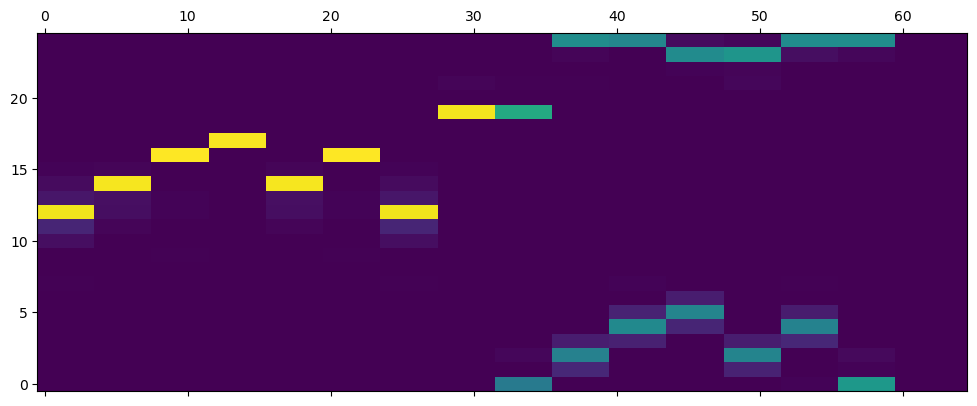

In [13]:
pitch_roll = sq_wave_dict.transcript_with_onsets(x, onsets, offsets)
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(12,8))
ax.matshow(abs(pitch_roll[0::1000]).T, origin="lower")